In [1]:
# Google Drive マウント
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# インポート
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

print('numpy version:', np.__version__)
print('tensorflow version:', tf.__version__)
print('GPU:', tf.test.gpu_device_name())

numpy version: 1.17.3
tensorflow version: 1.15.0
GPU: /device:GPU:0


In [0]:
# データ読み込み関数
def loadData(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1,
                      unpack=False, dtype=str)
    speed = []
    xyzwave = []
    for row in data:
        speed.append(row[1].astype('f8'))
        xyzwave.append(row[2: 2 + 3 * 50].astype('f8'))
    speed = np.array(speed)
    x = np.array(xyzwave)
    t = speed[:, np.newaxis]
    return x, t

In [0]:
# 入力・教師データを対応させたままシャッフル
def shuffleData(x, t):
    zipped = list(zip(x, t))
    np.random.shuffle(zipped)
    x_result, t_result = zip(*zipped)
    return np.asarray(x_result), np.asarray(t_result)

In [0]:
# 学習データとテストデータに分割
def splitData(x, t, ratio=0.9):
    border = int(len(x) * ratio)
    return (x[:border], t[:border]), (x[border:], t[border:])

In [0]:
# データの読み込み
folder = 'drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML/'
x1, t1 = loadData(folder + 'data/ML/1106_1059.csv')
x2, t2 = loadData(folder + 'data/ML/1106_1120.csv')
x3, t3 = loadData(folder + 'data/ML/1106_1136.csv')
x_train = np.concatenate([x1, x2, x3], axis=0)
t_train = np.concatenate([t1, t2, t3], axis=0)
x_train_shuffle, t_train_shuffle = shuffleData(x_train, t_train)
# (x_train_shuffle, t_train_shuffle), (x_test, t_test) = splitData(x_train_shuffle, t_train_shuffle)
x_test, t_test = loadData(folder + 'data/ML/1106_1152.csv')

In [0]:
# ハイパーパラメータ
activation = 'sigmoid'
learning_rate = 0.001
optimizer  ='adam'
loss = 'mse'

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


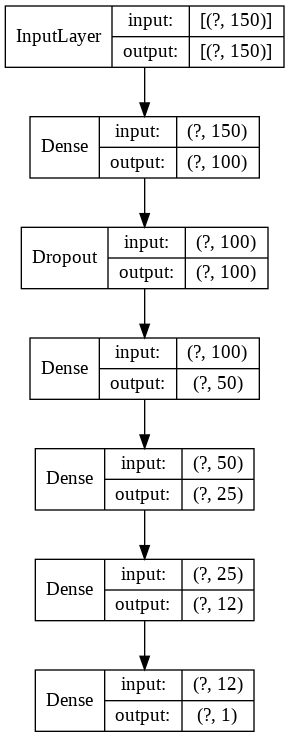

In [8]:
# モデル生成
model = keras.Sequential()
model.add(layers.Input(shape=(150,)))
model.add(layers.Dense(100, activation=activation))
model.add(layers.Dropout(0.2))
model.add(layers.Dense( 50, activation=activation))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense( 25, activation=activation))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense( 12, activation=activation))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(  1))

adam = keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=adam, loss=loss)

# モデルの可視化
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))
from tensorflow.keras.utils import plot_model
plot_model(model, to_file=folder+'graph/model.png',
           show_shapes=True, show_layer_names=False)

In [9]:
# モデルの訓練
result = model.fit(x_train_shuffle, t_train_shuffle, epochs=100)

Train on 2253 samples
Epoch 1/100
2253/2253 [==============================] - 4s 2ms/sample - loss: 0.3389
Epoch 2/100
2253/2253 [==============================] - 0s 65us/sample - loss: 0.1142
Epoch 3/100
2253/2253 [==============================] - 0s 69us/sample - loss: 0.1139
Epoch 4/100
2253/2253 [==============================] - 0s 62us/sample - loss: 0.1140
Epoch 5/100
2253/2253 [==============================] - 0s 75us/sample - loss: 0.1137
Epoch 6/100
2253/2253 [==============================] - 0s 71us/sample - loss: 0.1138
Epoch 7/100
2253/2253 [==============================] - 0s 81us/sample - loss: 0.1140
Epoch 8/100
2253/2253 [==============================] - 0s 78us/sample - loss: 0.1138
Epoch 9/100
2253/2253 [==============================] - 0s 80us/sample - loss: 0.1135
Epoch 10/100
2253/2253 [==============================] - 0s 65us/sample - loss: 0.1136
Epoch 11/100
2253/2253 [==============================] - 0s 69us/sample - loss: 0.1135
Epoch 12/100
2253/22

In [0]:
# 学習データでテスト
y_train = model.predict(x_train)
error_train = np.abs(t_train - y_train)

# テストデータでテスト
y_test = model.predict(x_test)
error_test  = np.abs(t_test - y_test)

In [11]:
errorRate_train = np.average(error_train) / np.average(t_train) * 100
errorRate_test  = np.average(error_test)  / np.average(t_test)  * 100
print('error_train_average = {} [%]'.format(errorRate_train))
print('error_test_average  = {} [%]'.format(errorRate_test))

error_train_average = 5.121599875885087 [%]
error_test_average  = 10.521964323362127 [%]


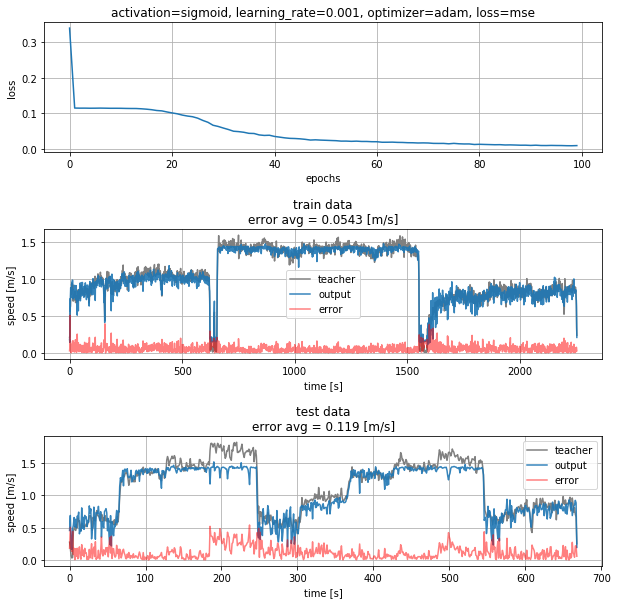

In [12]:
# グラフ表示
fig, axes = plt.subplots(3, 1, figsize=(10,10), facecolor='white')

axes[0].set_title('activation={}, '.format(activation) + 
                  'learning_rate={}, '.format(learning_rate) +
                  'optimizer={}, '.format(optimizer) + 
                  'loss={}'.format(loss))
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('loss')
axes[0].plot(result.history['loss'], label="training")
axes[0].grid()

axes[1].set_title('train data\n'
                  'error avg = {:.3} [m/s]'.format(np.average(error_train)))
axes[1].set_xlabel('time [s]')
axes[1].set_ylabel('speed [m/s]')
axes[1].plot(t_train, color='gray', label='teacher')
axes[1].plot(y_train, label='output', alpha=0.9)
axes[1].plot(error_train, color='red', label='error', alpha=0.5)
axes[1].legend()
axes[1].grid()

axes[2].set_title('test data\n'
                  'error avg = {:.3} [m/s]'.format(np.average(error_test)))
axes[2].set_xlabel('time [s]')
axes[2].set_ylabel('speed [m/s]')
axes[2].plot(t_test, color='gray', label='teacher')
axes[2].plot(y_test, label='output', alpha=0.9)
axes[2].plot(error_test, color='red', label='error', alpha=0.5)
axes[2].legend()
axes[2].grid()

plt.subplots_adjust(hspace=0.6)
fig.show()
fig.savefig(folder + 'graph/graph.png')